# pyxpcm for the Gulf of Mexico
Authors: Carolina Camargo, Chandana Mudeppa, Joseph Gum, Gui Castelao, Daniela Munguía

In [1]:
# Load libraries
import numpy as np
import pyxpcm
from pyxpcm.models import pcm
import xarray as xr
from argopy import DataFetcher as ArgoDataFetcher
import cartopy.crs as ccrs 
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import gsw

### Retrieve *raw* argo data and convert it to argo profiles

In [2]:
# Function to get argo data for a given lat,lon box (using Argopy), 
# and return a 2D array collection of vertical profile for the given region
#llon: left longitude
#rlon: right longtidue
#ulat: upper latitude
#llat: lower latitude
def get_argo_region_data(llon,rlon,llat,ulat,depthmin,depthmax,time_in,time_f):
    ds_points = ArgoDataFetcher(src='erddap').region([llon,rlon, llat,ulat, depthmin, depthmax,time_in,time_f]).to_xarray()
    ds_profiles = ds_points.argo.point2profile()
    return ds_profiles

In [3]:
# Function input parameters
# Bounding box
llon=-98;rlon=-80
ulat=31;llat=18
depthmin=0;depthmax=200
# Time range
time_in='2018-01'
time_f='2020-01'
# Run forest run (this can take a while..)
ds = get_argo_region_data(llon,rlon,llat,ulat,depthmin,depthmax,time_in,time_f)

In [4]:
# Display the data retrieved
print(ds)

<xarray.Dataset>
Dimensions:          (N_LEVELS: 199, N_PROF: 2864)
Coordinates:
  * N_PROF           (N_PROF) int64 173 249 766 634 341 ... 1268 11 2109 2149
    LONGITUDE        (N_PROF) float64 -89.41 -94.18 -96.14 ... -85.51 -85.75
    TIME             (N_PROF) datetime64[ns] 2018-01-01T01:24:26 ... 2019-12-...
    LATITUDE         (N_PROF) float64 24.82 26.43 21.48 ... 18.37 26.4 26.12
  * N_LEVELS         (N_LEVELS) int64 0 1 2 3 4 5 6 ... 193 194 195 196 197 198
Data variables:
    CYCLE_NUMBER     (N_PROF) int64 217 165 48 293 140 174 ... 21 187 231 21 20
    DATA_MODE        (N_PROF) <U1 'D' 'R' 'D' 'A' 'D' ... 'R' 'R' 'D' 'R' 'R'
    DIRECTION        (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_PROF) int64 4901479 4901480 4902350 ... 4903252 4903254
    POSITION_QC      (N_PROF) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    PRES             (N_PROF, N_LEVELS) float32 1.08 1.96 2.96 ... nan nan nan
    PRES_QC          (N_PROF) int64

#### Sort the dataset
In order to plot the positions of the floats by their `PLATFORM_NUMBER`

In [5]:
ds = ds.sortby('PLATFORM_NUMBER', ascending=True)
#Uncoment next line if you want to save a netCDF with the argo data
#ds.to_netcdf('argos-gom-012018-012020.nc')
# Values and total number of floats in our data set
platformNumbers = np.unique(ds['PLATFORM_NUMBER'].values)
nPlatformNumbers = len(platformNumbers)
nProfiles = len(ds['PLATFORM_NUMBER'])
# Create an array of numbers that represent each float
colors = np.linspace(1,nPlatformNumbers,nProfiles)

### Map the positions of the floats

**Plot the floats in the Gulf of Mexico and color them by float**

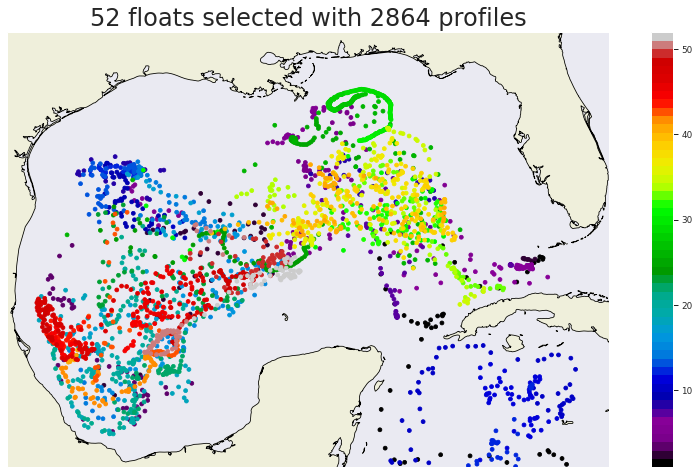

In [6]:
plt.figure(figsize=(15,8))    
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([llon,rlon,llat,ulat])
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
kmap = plt.get_cmap('nipy_spectral',nPlatformNumbers)
sc = ax.scatter(ds['LONGITUDE'], ds['LATITUDE'], s=15,c=colors,cmap=kmap)
plt.colorbar(sc, ax=ax)
plt.title(str(nPlatformNumbers) + ' floats selected with '+ str(nProfiles) + ' profiles',fontsize=24)
plt.show()

### Check QC

According to Argo manual: 
- QC flag values of 1, 2, 5, or 8 are GOOD data
- QC flag values of 9 (missing) are NOT USED in the computation
- All other QC flag values are BAD data 

Page 57 in http://www.odip.org/documents/odip/downloads/20/argo-dm-user-manual.pdf

**Find flags of good and bad data**

In [7]:
goodflags=[1,2,5,8]
badflags=[3,4,6,7,9]
QC=['POSITION_QC','PRES_QC','TEMP_QC','PSAL_QC','TIME_QC']
for q in QC:
    data=np.array(ds[q])
    for f in badflags:
        if np.any(data)==f: 
            print('Bad data in '+str(q)+' QC flag: '+str(f))

### Delayed X Real time Data

DATA_MODE(PROF_N):

R : real time data

D : delayed mode data

A : real time data with adjusted values

In [8]:
ds.DATA_MODE

<xarray.DataArray 'DATA_MODE' (N_PROF: 2864)>
array(['D', 'D', 'D', ..., 'D', 'D', 'D'], dtype='<U1')
Coordinates:
  * N_PROF     (N_PROF) int64 6 7 8 9 10 11 12 ... 2858 2859 2860 2861 2862 2863
    LONGITUDE  (N_PROF) float64 -81.28 -81.41 -81.66 ... -90.45 -90.64 -90.66
    TIME       (N_PROF) datetime64[ns] 2019-12-16T12:48:30 ... 2019-12-27T11:...
    LATITUDE   (N_PROF) float64 18.07 18.25 18.36 18.48 ... 23.79 23.72 23.72
Attributes:
    casted:   1

**Select only delayed mode data ('D')**

In [9]:
ds2=ds.where(ds.DATA_MODE=='D',drop=True)
print('We selected '+str(len(ds2.N_PROF))+' from '+str(len(ds.N_PROF)))
ds2

We selected 2053 from 2864


<xarray.Dataset>
Dimensions:          (N_LEVELS: 199, N_PROF: 2053)
Coordinates:
  * N_PROF           (N_PROF) int64 6 7 8 9 10 11 ... 2859 2860 2861 2862 2863
    LONGITUDE        (N_PROF) float64 -81.28 -81.41 -81.66 ... -90.64 -90.66
    TIME             (N_PROF) datetime64[ns] 2019-12-16T12:48:30 ... 2019-12-...
    LATITUDE         (N_PROF) float64 18.07 18.25 18.36 ... 23.79 23.72 23.72
  * N_LEVELS         (N_LEVELS) int64 0 1 2 3 4 5 6 ... 193 194 195 196 197 198
Data variables:
    CYCLE_NUMBER     (N_PROF) float64 226.0 227.0 228.0 ... 99.0 100.0 101.0
    DATA_MODE        (N_PROF) object 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D' 'D'
    DIRECTION        (N_PROF) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_PROF) float64 3.902e+06 3.902e+06 ... 6.903e+06
    POSITION_QC      (N_PROF) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    PRES             (N_PROF, N_LEVELS) float32 2.9 4.0 5.3 6.2 ... nan nan nan
    PRES_QC          (N_PROF) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    PSAL             (N_PROF, N_LEVELS) float32 35.806 35.805 35.805 ... nan nan
    PSAL_QC          (N_PROF) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    TEMP             (N_PROF, N_LEVELS) float32 28.594 28.601 28.601 ... nan nan
    TEMP_QC          (N_PROF) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    TIME_QC          (N_PROF) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           jovyan
    Fetched_date:         2020/08/14
    Fetched_constraints:  phy_[x=-98.00/-80.00; y=18.00/31.00; z=0.0/200.0; t...
    Fetched_uri:          https://www.ifremer.fr/erddap/tabledap/ArgoFloats.n...
    history:              Variables filtered according to DATA_MODE; Variable...

### Vertical Interpolation

' We finally interpolated the data on a regular vertical grid with a 5 m resolution (the original resolution ranges from less than 10 m at the surface to 200 m at the bottom of the profile)' - maze et al. 2017

In [10]:
z=np.arange(0.,depthmax,5.)
ds3 = ds2.argo.interp_std_levels(z)
#ds3=ds_interp
print(ds3)

<xarray.Dataset>
Dimensions:            (N_PROF: 1730, PRES_INTERPOLATED: 40)
Coordinates:
  * N_PROF             (N_PROF) int64 6 7 8 9 10 11 ... 2859 2860 2861 2862 2863
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) float64 0.0 5.0 10.0 ... 190.0 195.0
    LONGITUDE          (N_PROF) float64 -81.28 -81.41 -81.66 ... -90.64 -90.66
    TIME               (N_PROF) datetime64[ns] 2019-12-16T12:48:30 ... 2019-1...
    LATITUDE           (N_PROF) float64 18.07 18.25 18.36 ... 23.79 23.72 23.72
Data variables:
    CYCLE_NUMBER       (N_PROF) float64 226.0 227.0 228.0 ... 99.0 100.0 101.0
    DATA_MODE          (N_PROF) object 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    DIRECTION          (N_PROF) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER    (N_PROF) float64 3.902e+06 3.902e+06 ... 6.903e+06
    PRES               (N_PROF, PRES_INTERPOLATED) float32 2.9 5.0 ... 195.0
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 35.806 ... 36.241295
    TEMP               (

In [11]:
print('The number of profiles changed from  '+ str(len(ds2.N_PROF))+ ' to '+ str(len(ds3.N_PROF)))

The number of profiles changed from  2053 to 1730


## Pressure to Depth

**Create array of depths from pressure values using the function `gsw.z_from_p`** 

In [12]:
p=np.array(ds3.PRES)
lat=np.array(ds3.LATITUDE)
z=np.ones_like(p)
nprof=np.array(ds3.N_PROF)
#z=gsw.z_from_p(p,lat)
for i in np.arange(0,len(nprof)):
    z[i,:]=gsw.z_from_p(p[i,:], lat[i])

In [13]:
p_interp=np.array(ds3.PRES_INTERPOLATED)
z_interp=gsw.z_from_p(p_interp, 25) # choosing a mid latitude of the basin

### Make a clean dataset 

We could use ds.drop_vars() or ds.drop_dims() also

**Create arrays of depths, latitudes, longitudes, times, temperatures and salinities**

In [14]:
temp=np.array(ds3.TEMP)
sal=np.array(ds3.PSAL)
depth_var=z
depth=z_interp
lat=np.array(ds3.LATITUDE)
lon=np.array(ds3.LONGITUDE)
time=np.array(ds3.TIME)

**Create clean DataSet**

In [15]:
da=xr.Dataset(data_vars={'TEMP':(('N_PROF','DEPTH'),temp),
                        'PSAL':(('N_PROF','DEPTH'),sal),
                        'TIME':(('N_PROF'),time),
                         'LATITUDE':(('N_PROF'),lat),
                         'LONGITUDE':(('N_PROF'),lon),
                         'DEPTH_PROF':(('N_PROF','DEPTH'),depth_var)
                        },
                         coords={'N_PROF':nprof,
                                'DEPTH':depth})
da

<xarray.Dataset>
Dimensions:     (DEPTH: 40, N_PROF: 1730)
Coordinates:
  * N_PROF      (N_PROF) int64 6 7 8 9 10 11 ... 2858 2859 2860 2861 2862 2863
  * DEPTH       (DEPTH) float64 -0.0 -4.968 -9.935 ... -183.7 -188.7 -193.7
Data variables:
    TEMP        (N_PROF, DEPTH) float32 28.594 28.601 ... 17.088 16.899454
    PSAL        (N_PROF, DEPTH) float32 35.806 35.805 ... 36.2675 36.241295
    TIME        (N_PROF) datetime64[ns] 2019-12-16T12:48:30 ... 2019-12-27T11...
    LATITUDE    (N_PROF) float64 18.07 18.25 18.36 18.48 ... 23.79 23.72 23.72
    LONGITUDE   (N_PROF) float64 -81.28 -81.41 -81.66 ... -90.45 -90.64 -90.66
    DEPTH_PROF  (N_PROF, DEPTH) float32 -2.882588 -4.9699535 ... -193.6719

### Make model
**Create basic PCM with, K number of clusters and temperature and salinity from argo data as features of the model**

In [16]:
z = np.arange(0.,-200,-10.) # depth array
pcm_features = {'temperature': z, 'salinity':z} #features that vary in function of depth
m = pcm(K=6, features=pcm_features) # create the 'basic' model
m

<pcm 'gmm' (K: 6, F: 2)>
Number of class: 6
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

### Fit model
**Declare features and dimension to fit the model**

In [17]:
features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}
features_zdim='DEPTH'
m.fit(da, features=features_in_ds, dim=features_zdim)
m
da['TEMP'].attrs['feature_name'] = 'temperature'
da['PSAL'].attrs['feature_name'] = 'salinity'
da['DEPTH'].attrs['axis'] = 'Z'

### Classify the data

In [18]:
m.predict(da, features=features_in_ds, dim=features_zdim,inplace=True)
da

<xarray.Dataset>
Dimensions:     (DEPTH: 40, N_PROF: 1730)
Coordinates:
  * N_PROF      (N_PROF) int64 6 7 8 9 10 11 ... 2858 2859 2860 2861 2862 2863
  * DEPTH       (DEPTH) float64 -0.0 -4.968 -9.935 ... -183.7 -188.7 -193.7
Data variables:
    TEMP        (N_PROF, DEPTH) float32 28.594 28.601 ... 17.088 16.899454
    PSAL        (N_PROF, DEPTH) float32 35.806 35.805 ... 36.2675 36.241295
    TIME        (N_PROF) datetime64[ns] 2019-12-16T12:48:30 ... 2019-12-27T11...
    LATITUDE    (N_PROF) float64 18.07 18.25 18.36 18.48 ... 23.79 23.72 23.72
    LONGITUDE   (N_PROF) float64 -81.28 -81.41 -81.66 ... -90.45 -90.64 -90.66
    DEPTH_PROF  (N_PROF, DEPTH) float32 -2.882588 -4.9699535 ... -193.6719
    PCM_LABELS  (N_PROF) int64 1 2 1 3 2 1 2 2 2 2 2 2 ... 5 5 1 0 1 1 0 0 1 1 1

In [19]:
m.predict_proba(da, features=features_in_ds, inplace=True)
da

<xarray.Dataset>
Dimensions:     (DEPTH: 40, N_PROF: 1730, pcm_class: 6)
Coordinates:
  * N_PROF      (N_PROF) int64 6 7 8 9 10 11 ... 2858 2859 2860 2861 2862 2863
  * DEPTH       (DEPTH) float64 -0.0 -4.968 -9.935 ... -183.7 -188.7 -193.7
Dimensions without coordinates: pcm_class
Data variables:
    TEMP        (N_PROF, DEPTH) float32 28.594 28.601 ... 17.088 16.899454
    PSAL        (N_PROF, DEPTH) float32 35.806 35.805 ... 36.2675 36.241295
    TIME        (N_PROF) datetime64[ns] 2019-12-16T12:48:30 ... 2019-12-27T11...
    LATITUDE    (N_PROF) float64 18.07 18.25 18.36 18.48 ... 23.79 23.72 23.72
    LONGITUDE   (N_PROF) float64 -81.28 -81.41 -81.66 ... -90.45 -90.64 -90.66
    DEPTH_PROF  (N_PROF, DEPTH) float32 -2.882588 -4.9699535 ... -193.6719
    PCM_LABELS  (N_PROF) int64 1 2 1 3 2 1 2 2 2 2 2 2 ... 5 5 1 0 1 1 0 0 1 1 1
    PCM_POST    (pcm_class, N_PROF) float64 1.046e-18 1.184e-32 ... 4.328e-27

**Get the 0.05, 0.5 and 0.95 quantiles of the model features**

In [20]:
for vname in ['TEMP', 'PSAL']:
    da = da.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=vname, outname=vname + '_Q', keep_attrs=True, inplace=True)
da

<xarray.Dataset>
Dimensions:     (DEPTH: 40, N_PROF: 1730, pcm_class: 6, quantile: 3)
Coordinates:
  * pcm_class   (pcm_class) int64 0 1 2 3 4 5
  * N_PROF      (N_PROF) int64 6 7 8 9 10 11 ... 2858 2859 2860 2861 2862 2863
  * DEPTH       (DEPTH) float64 -0.0 -4.968 -9.935 ... -183.7 -188.7 -193.7
  * quantile    (quantile) float64 0.05 0.5 0.95
Data variables:
    TEMP        (N_PROF, DEPTH) float32 28.594 28.601 ... 17.088 16.899454
    PSAL        (N_PROF, DEPTH) float32 35.806 35.805 ... 36.2675 36.241295
    TIME        (N_PROF) datetime64[ns] 2019-12-16T12:48:30 ... 2019-12-27T11...
    LATITUDE    (N_PROF) float64 18.07 18.25 18.36 18.48 ... 23.79 23.72 23.72
    LONGITUDE   (N_PROF) float64 -81.28 -81.41 -81.66 ... -90.45 -90.64 -90.66
    DEPTH_PROF  (N_PROF, DEPTH) float32 -2.882588 -4.9699535 ... -193.6719
    PCM_LABELS  (N_PROF) int64 1 2 1 3 2 1 2 2 2 2 2 2 ... 5 5 1 0 1 1 0 0 1 1 1
    PCM_POST    (pcm_class, N_PROF) float64 1.046e-18 1.184e-32 ... 4.328e-27
    TEMP_Q      (pcm_class, quantile, DEPTH) float64 22.96 22.96 ... 17.11 16.92
    PSAL_Q      (pcm_class, quantile, DEPTH) float64 35.33 35.35 ... 36.3 36.27

### Plot the vertical distribution of the PCMs output
**Temperature**

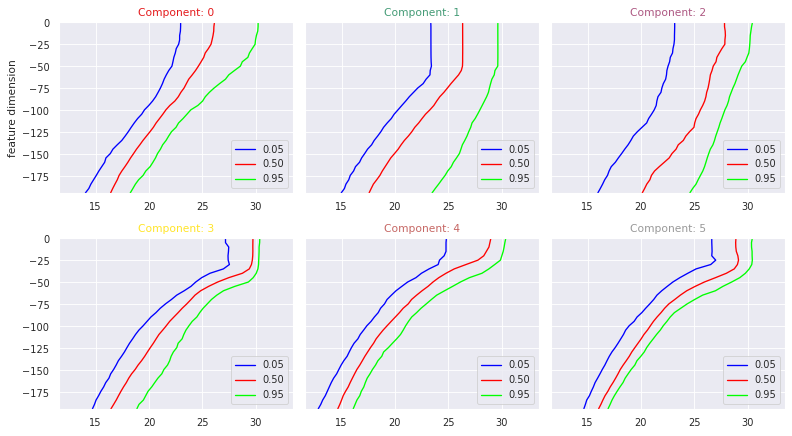

In [21]:
fig, ax = m.plot.quantile(da['TEMP_Q'], maxcols=3, figsize=(10, 8), sharey=True)

**Salinity**

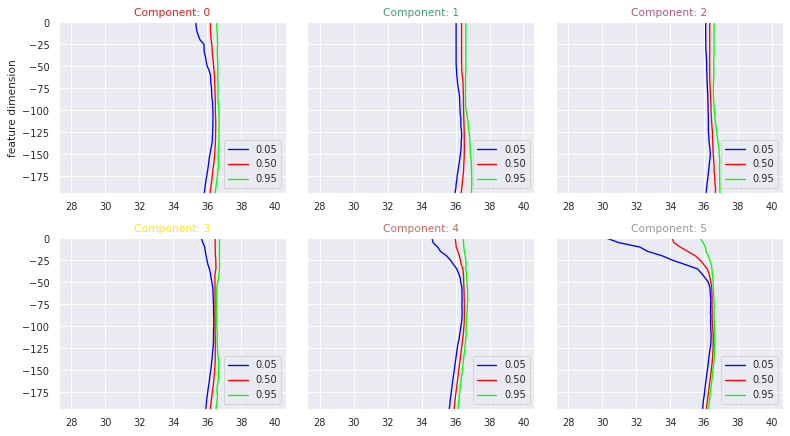

In [22]:
fig, ax = m.plot.quantile(da['PSAL_Q'], maxcols=3, figsize=(10, 8), sharey=True)

### Plot the horizontal distribution of the PCMs clusters ### 

/home/jovyan/my-conda-envs/ohw20-proj-pyxpcm/lib/python3.8/site-packages/pyxpcm/plot.py:111: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  colorbar = plt.colorbar(mappable, **kwargs)
/home/jovyan/my-conda-envs/ohw20-proj-pyxpcm/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/jovyan/my-conda-envs/ohw20-proj-pyxpcm/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


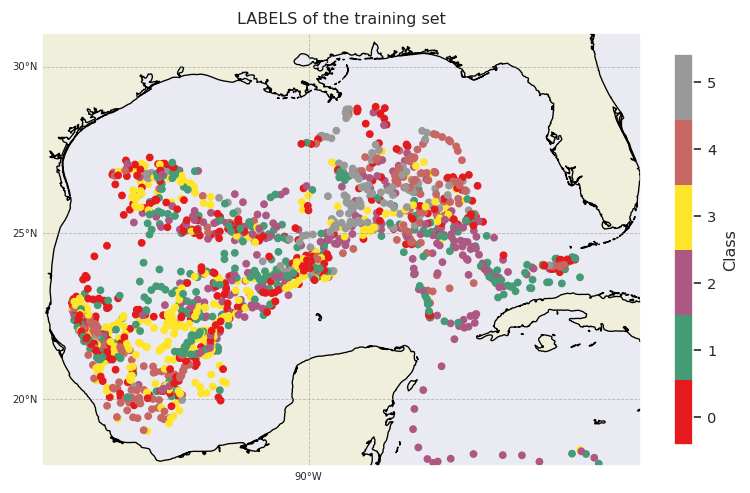

In [23]:
ds=da
proj = ccrs.PlateCarree();
plt.figure(figsize=(7,7),dpi=120, facecolor='w', edgecolor='k');    
ax = plt.subplot(111, projection=proj);
ax.set_extent([llon,rlon,llat,ulat]);
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
kmap = m.plot.cmap();
sc = ax.scatter(ds['LONGITUDE'], ds['LATITUDE'], s=15, c=ds['PCM_LABELS'], cmap=kmap, transform=proj, vmin=0, vmax=m.K);
cl = m.plot.colorbar(ax=ax);
ax.set_title('LABELS of the training set');
gl = m.plot.latlongrid(ax, dx=10);
plt.show();